In [307]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
import random

In [308]:
# Configuration parameters (matching the original notebook)
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 100
LSTM_MODEL_SAVE_PATH = "lstm_model.keras"
GRU_MODEL_SAVE_PATH = "gru_model.keras"
TextCNN_MODEL_SAVE_PATH = "textCNN_model.keras"
BEST_THRESHOLD = 0.6

In [309]:
# Download necessary NLTK resources (commented out as in original)
# nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)

In [310]:
def preprocess_text(text):
    """Preprocess individual text (same as in notebook)"""
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [311]:
def combine_text(df):
    """Concatenate statement with relevant metadata fields (same as in notebook)"""
    df = df.fillna('')
    combined = (
        df[2].astype(str) + " " +  # statement
        df[3].astype(str) + " " +  # subject(s)
        df[4].astype(str) + " " +  # speaker
        df[5].astype(str) + " " +  # speaker's job title
        df[6].astype(str) + " " +  # state info
        df[7].astype(str) + " " +  # party affiliation
        df[13].astype(str)         # context (venue/location)
    )
    return combined.tolist()

In [312]:
def replace_labels(label):
    """Convert multi-class labels to binary classification (same as in notebook)"""
    label = label.lower().replace(" ", "-")
    return "true" if label in ["true", "mostly-true"] else "false"

In [313]:
# Load the test dataset
TEST_PATH = "liar_dataset/test.tsv"
test_df = pd.read_csv(TEST_PATH, sep='\t', header=None)

# Select 10 random statements
# random_indices = random.sample(range(len(test_df)), 50)
# sample_df = test_df.iloc[random_indices]

sample_df = test_df

# sample_df = test_df.iloc[[1]]

# sample_df = test_df.iloc[[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]

# Combine text fields
sample_statements = combine_text(sample_df)

# Preprocess the statements
sample_statements_processed = [preprocess_text(statement) for statement in sample_statements]

In [314]:
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,34,7,a news conference
1263,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,1,0,"on ABC's ""This Week"""
1264,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,0,0,a commentary in The Providence Journal
1265,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9,8,10,18,3,a news conference


In [315]:
# Load the saved tokenizer
with open('preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)
tokenizer = preprocessed_data.get('tokenizer', None)
if tokenizer is None:
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(sample_statements_processed)  # Fallback, though ideally use saved tokenizer

# Convert to sequences and pad
sequences = tokenizer.texts_to_sequences(sample_statements_processed)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Load the saved model
lstm_model = tf.keras.models.load_model(LSTM_MODEL_SAVE_PATH)

# Make predictions
lstm_predictions = lstm_model.predict(padded_sequences, verbose=0)
lstm_predicted_classes = (lstm_predictions > BEST_THRESHOLD).astype(int).flatten()

# Load the saved model
gru_model = tf.keras.models.load_model(GRU_MODEL_SAVE_PATH)

# Make predictions
gru_predictions = gru_model.predict(padded_sequences, verbose=0)
gru_predicted_classes = (gru_predictions > BEST_THRESHOLD).astype(int).flatten()

# Load the saved model
textcnn_model = tf.keras.models.load_model(TextCNN_MODEL_SAVE_PATH)

# Make predictions
textcnn_predictions = textcnn_model.predict(padded_sequences, verbose=0)
textcnn_predicted_classes = (textcnn_predictions > BEST_THRESHOLD).astype(int).flatten()

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [316]:
# print(lstm_predictions)
# print(lstm_predicted_classes)

# print(gru_predictions)
# print(gru_predicted_classes)

# print(textcnn_predictions)
# print(textcnn_predicted_classes)

In [317]:
final_predictions = (lstm_predictions + gru_predictions + textcnn_predictions) / 3
final_predicted_classes = (final_predictions > BEST_THRESHOLD).astype(int).flatten()

# print(final_predictions)
# print(final_predicted_classes)

In [318]:
# Map labels for true classes
true_labels = [replace_labels(label) for label in sample_df[1].tolist()]
true_classes = [1 if label == "true" else 0 for label in true_labels]

In [319]:
# Prepare data for DataFrame
results = {
    'Statement': [statement[:100] + "..." if len(statement) > 100 else statement for statement in sample_statements],
    'True Label': true_labels,
    'LSTM Predicted Probability': [f"{prob:.4f}" for prob in lstm_predictions.flatten()],
    'GRU Predicted Probability': [f"{prob:.4f}" for prob in gru_predictions.flatten()],
    'TextCNN Predicted Probability': [f"{prob:.4f}" for prob in textcnn_predictions.flatten()],
    'Ensemble Predicted Probability': [f"{prob:.4f}" for prob in final_predictions.flatten()],
    'LSTM Predicted Class': ['true' if pred == 1 else 'false' for pred in lstm_predicted_classes],
    'GRU Predicted Class': ['true' if pred == 1 else 'false' for pred in gru_predicted_classes],
    'TextCNN Predicted Class': ['true' if pred == 1 else 'false' for pred in textcnn_predicted_classes],
    'Ensemble Predicted Class': ['true' if pred == 1 else 'false' for pred in final_predicted_classes],
    'Correct': [true_label == ('true' if pred == 1 else 'false') for true_label, pred in zip(true_labels, final_predicted_classes)]
}

# Create DataFrame
results_df = pd.DataFrame(results)

In [320]:
results_df

,Statement,True Label,LSTM Predicted Probability,GRU Predicted Probability,TextCNN Predicted Probability,Ensemble Predicted Probability,LSTM Predicted Class,GRU Predicted Class,TextCNN Predicted Class,Ensemble Predicted Class,Correct
0,Building a wall on the U.S.-Mexico border will...,true,0.2828,0.2203,0.3683,0.2905,false,false,false,false,False
1,Wisconsin is on pace to double the number of l...,false,0.5908,0.5219,0.5907,0.5678,false,false,false,false,True
2,Says John McCain has done nothing to help the ...,false,0.2569,0.1965,0.2386,0.2307,false,false,false,false,True
3,Suzanne Bonamici supports a plan that will cut...,false,0.1778,0.1136,0.2773,0.1896,false,false,false,false,True
4,When asked by a reporter whether hes at the ce...,false,0.4211,0.4905,0.3389,0.4168,false,false,false,false,True
...,...,...,...,...,...,...,...,...,...,...,...
1262,Says his budget provides the highest state fun...,false,0.5693,0.5832,0.5458,0.5661,false,false,false,false,True
1263,"Ive been here almost every day. civil-rights,c...",false,0.7216,0.7574,0.5580,0.6790,true,true,false,true,False
1264,"In the early 1980s, Sen. Edward Kennedy secret...",false,0.4743,0.5164,0.4853,0.4920,false,false,false,false,True
1265,Says an EPA permit languished under Strickland...,false,0.4440,0.7039,0.5485,0.5655,false,true,false,false,True


In [321]:
# Calculate accuracy for these 10 samples
lstm_accuracy = sum(1 for t, p in zip(true_classes, lstm_predicted_classes) if t == p) / len(true_classes)
gru_accuracy = sum(1 for t, p in zip(true_classes, gru_predicted_classes) if t == p) / len(true_classes)
textcnn_accuracy = sum(1 for t, p in zip(true_classes, textcnn_predicted_classes) if t == p) / len(true_classes)
final_accuracy = sum(1 for t, p in zip(true_classes, final_predicted_classes) if t == p) / len(true_classes)
print(f"LSMT Accuracy for these samples: {lstm_accuracy:.4f}")
print(f"GRU Accuracy for these samples: {gru_accuracy:.4f}")
print(f"TextCNN Accuracy for these samples: {textcnn_accuracy:.4f}")
print(f"Final Accuracy for these samples: {final_accuracy:.4f}")

LSMT Accuracy for these samples: 0.6654
GRU Accuracy for these samples: 0.6338
TextCNN Accuracy for these samples: 0.6559
Final Accuracy for these samples: 0.6725


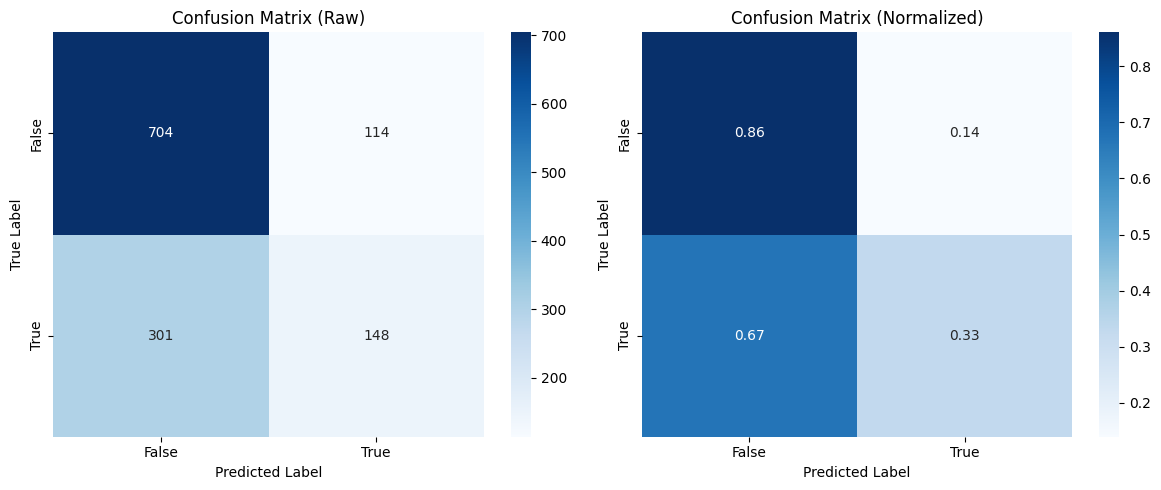

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

true_binary = [1 if label == 'true' else 0 for label in true_labels]
pred_binary = final_predicted_classes.tolist()

# Compute confusion matrix
cm = confusion_matrix(true_binary, pred_binary)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['False', 'True']

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Confusion Matrix (Raw)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()